In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import time
from keras.applications import vgg16
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential,load_model
from keras.utils import to_categorical
import keras
from keras.layers import InputLayer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
data_path = '/home/vishwajeet/Documents/Summer_Project_FER/CK+_model/CK+48/'
data_dir_list = os.listdir(data_path)

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.resize(input_img,(224,224))
        img_data_list.append(input_img)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-happy

Loaded the images of dataset-anger

Loaded the images of dataset-surprise

Loaded the images of dataset-sadness

Loaded the images of dataset-disgust

Loaded the images of dataset-fear



(927, 224, 224, 3)

In [3]:
num_classes = 6

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:135]=0 #135
labels[135:312]=1 #177
labels[312:387]=2 #75
labels[387:594]=3 #207
labels[594:678]=4 #84
labels[678:927]=5 #249

# labels =to_categorical(labels, num_classes)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [4]:
input_shape=(224,224,3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape,)

out = vgg.output
out = Flatten(name='flatten')(out)
out = Dense(4096, activation='relu', name='fc1')(out)
out = Dense(4096, activation='relu', name='fc2')(out)
out = Dense(num_classes, activation='softmax', name='predictions')(out)
vgg_model = Model(vgg.input, out)

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['predictions']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fbb7df3d490>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7fbb789790d0>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7fbb7c2e23d0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7fbb50e1ea10>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7fbb2bf3c550>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7fbb2bf71950>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fbb2bf71e90>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7fbb2bf5ba90>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7fbb2846e150>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7fbb2846ee10>,block3_conv3,False


In [5]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [6]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(img_data, labels)

10

In [7]:
import matplotlib.pyplot as plt
def cnn_model(x_train,x_test,y_test,y_train):
    model = Sequential()
    model.add(vgg_model)
    model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 


    history=model.fit(x_train, y_train, epochs=35, batch_size=80,verbose=1)
    model.compile(loss = "categorical_crossentropy",optimizer = Adam(), metrics=['accuracy'],)

    loss,acc = model.evaluate(x_test, y_test)
    y_prediction = model.predict_classes(x_test)
    y_test_original=np.argmax(y_test,axis=1)
    confusion=confusion_matrix(y_true=y_test_original, y_pred=y_prediction)
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.title('model history')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    graph=plt.show()
    return acc,confusion,graph

Epoch 1/35
832/832 [==============================] - 145s 174ms/step - loss: 1.7399 - accuracy: 0.2380
Epoch 2/35
832/832 [==============================] - 137s 164ms/step - loss: 1.6815 - accuracy: 0.3221
Epoch 3/35
832/832 [==============================] - 121s 145ms/step - loss: 1.6516 - accuracy: 0.3834
Epoch 4/35
832/832 [==============================] - 120s 145ms/step - loss: 1.6265 - accuracy: 0.4002
Epoch 5/35
832/832 [==============================] - 120s 144ms/step - loss: 1.6058 - accuracy: 0.3822
Epoch 6/35
832/832 [==============================] - 120s 144ms/step - loss: 1.5822 - accuracy: 0.4483
Epoch 7/35
832/832 [==============================] - 120s 144ms/step - loss: 1.5596 - accuracy: 0.4543
Epoch 8/35
832/832 [==============================] - 121s 145ms/step - loss: 1.5408 - accuracy: 0.4651
Epoch 9/35
832/832 [==============================] - 129s 156ms/step - loss: 1.5183 - accuracy: 0.4748
Epoch 10/35
832/832 [==============================] - 121s 146m

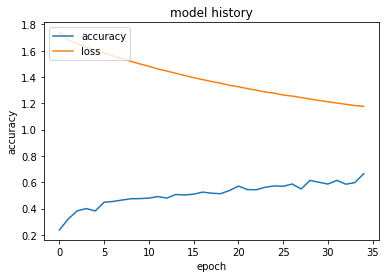

0.5684210658073425
[[ 9  1  0  0  0  4]
 [11  0  0  0  0  7]
 [ 0  4  0  0  0  4]
 [ 0  0  0 20  0  1]
 [ 0  0  0  4  0  5]
 [ 0  0  0  0  0 25]]
None
----------------------------
Epoch 1/35
832/832 [==============================] - 123s 148ms/step - loss: 1.1742 - accuracy: 0.5998
Epoch 2/35
832/832 [==============================] - 123s 148ms/step - loss: 1.1618 - accuracy: 0.6803
Epoch 3/35
832/832 [==============================] - 126s 151ms/step - loss: 1.1544 - accuracy: 0.5769
Epoch 4/35
832/832 [==============================] - 122s 147ms/step - loss: 1.1447 - accuracy: 0.6575
Epoch 5/35
832/832 [==============================] - 120s 144ms/step - loss: 1.1323 - accuracy: 0.6382
Epoch 6/35
832/832 [==============================] - 122s 147ms/step - loss: 1.1260 - accuracy: 0.6490
Epoch 7/35
832/832 [==============================] - 122s 147ms/step - loss: 1.1162 - accuracy: 0.6526
Epoch 8/35
832/832 [==============================] - 122s 147ms/step - loss: 1.1058 - accur

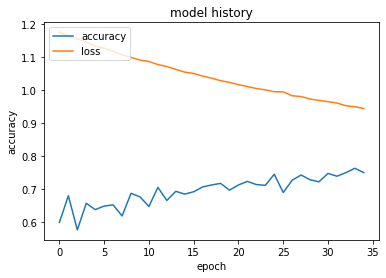

0.6526315808296204
[[13  1  0  0  0  0]
 [15  2  0  0  0  1]
 [ 0  7  0  0  0  1]
 [ 0  0  1 19  0  1]
 [ 0  1  0  1  3  4]
 [ 0  0  0  0  0 25]]
None
----------------------------
Epoch 1/35
832/832 [==============================] - 118s 142ms/step - loss: 0.9454 - accuracy: 0.7584
Epoch 2/35
832/832 [==============================] - 120s 145ms/step - loss: 0.9370 - accuracy: 0.7272
Epoch 3/35
832/832 [==============================] - 122s 147ms/step - loss: 0.9304 - accuracy: 0.7476
Epoch 4/35
832/832 [==============================] - 120s 144ms/step - loss: 0.9248 - accuracy: 0.7560
Epoch 5/35
832/832 [==============================] - 120s 144ms/step - loss: 0.9202 - accuracy: 0.7524
Epoch 6/35
832/832 [==============================] - 120s 144ms/step - loss: 0.9161 - accuracy: 0.7560
Epoch 7/35
832/832 [==============================] - 120s 144ms/step - loss: 0.9121 - accuracy: 0.7668
Epoch 8/35
832/832 [==============================] - 120s 144ms/step - loss: 0.9070 - accur

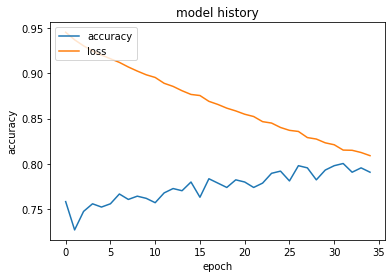

0.6842105388641357
[[ 8  4  0  0  0  2]
 [11  7  0  0  0  0]
 [ 0  7  0  0  1  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  5  4]
 [ 0  0  0  0  0 25]]
None
----------------------------
Epoch 1/35
832/832 [==============================] - 118s 142ms/step - loss: 0.8078 - accuracy: 0.7897
Epoch 2/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8064 - accuracy: 0.8149
Epoch 3/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8006 - accuracy: 0.7981
Epoch 4/35
832/832 [==============================] - 120s 144ms/step - loss: 0.7958 - accuracy: 0.8041
Epoch 5/35
832/832 [==============================] - 122s 147ms/step - loss: 0.7973 - accuracy: 0.8017
Epoch 6/35
832/832 [==============================] - 121s 145ms/step - loss: 0.7882 - accuracy: 0.8065
Epoch 7/35
832/832 [==============================] - 121s 145ms/step - loss: 0.7859 - accuracy: 0.8005
Epoch 8/35
832/832 [==============================] - 120s 144ms/step - loss: 0.7845 - accur

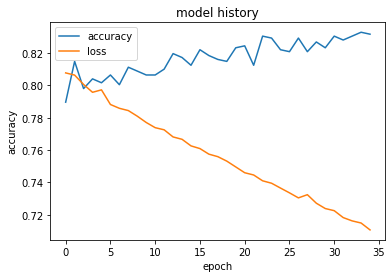

0.6842105388641357
[[10  0  0  0  0  4]
 [16  1  0  0  0  1]
 [ 0  5  1  1  1  0]
 [ 0  0  0 20  0  1]
 [ 0  1  0  0  8  0]
 [ 0  0  0  0  0 25]]
None
----------------------------
Epoch 1/35
833/833 [==============================] - 120s 144ms/step - loss: 0.7430 - accuracy: 0.7947
Epoch 2/35
833/833 [==============================] - 122s 146ms/step - loss: 0.7376 - accuracy: 0.8067
Epoch 3/35
833/833 [==============================] - 122s 146ms/step - loss: 0.7381 - accuracy: 0.8031
Epoch 4/35
833/833 [==============================] - 131s 157ms/step - loss: 0.7316 - accuracy: 0.8055
Epoch 5/35
833/833 [==============================] - 127s 153ms/step - loss: 0.7300 - accuracy: 0.8067
Epoch 6/35
833/833 [==============================] - 123s 147ms/step - loss: 0.7272 - accuracy: 0.8007
Epoch 7/35
833/833 [==============================] - 121s 146ms/step - loss: 0.7266 - accuracy: 0.8055
Epoch 8/35
833/833 [==============================] - 122s 146ms/step - loss: 0.7217 - accur

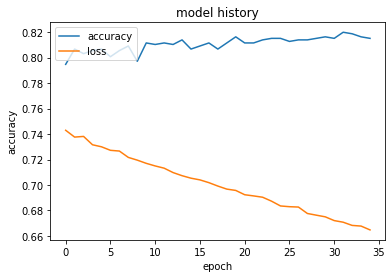

0.914893627166748
[[14  0  0  0  0  0]
 [ 0 17  0  0  0  1]
 [ 0  0  2  6  0  0]
 [ 0  0  0 21  0  0]
 [ 0  0  0  0  7  1]
 [ 0  0  0  0  0 25]]
None
----------------------------
Epoch 1/35
835/835 [==============================] - 121s 145ms/step - loss: 0.6638 - accuracy: 0.8180
Epoch 2/35
835/835 [==============================] - 123s 147ms/step - loss: 0.6619 - accuracy: 0.8216
Epoch 3/35
835/835 [==============================] - 122s 146ms/step - loss: 0.6569 - accuracy: 0.8204
Epoch 4/35
835/835 [==============================] - 125s 150ms/step - loss: 0.6560 - accuracy: 0.8180
Epoch 5/35
835/835 [==============================] - 140s 168ms/step - loss: 0.6546 - accuracy: 0.8192
Epoch 6/35
835/835 [==============================] - 126s 151ms/step - loss: 0.6506 - accuracy: 0.8251
Epoch 7/35
835/835 [==============================] - 123s 147ms/step - loss: 0.6499 - accuracy: 0.8240
Epoch 8/35
835/835 [==============================] - 123s 147ms/step - loss: 0.6486 - accura

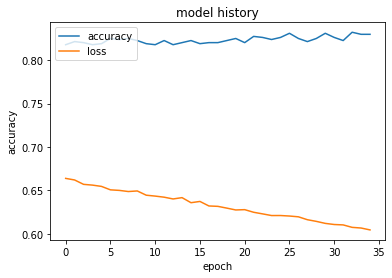

0.8913043737411499
[[12  1  0  0  0  0]
 [ 0 18  0  0  0  0]
 [ 0  0  0  7  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  8  0]
 [ 0  1  0  0  0 24]]
None
----------------------------
Epoch 1/35
835/835 [==============================] - 121s 145ms/step - loss: 0.6125 - accuracy: 0.8287
Epoch 2/35
835/835 [==============================] - 127s 152ms/step - loss: 0.6087 - accuracy: 0.8275
Epoch 3/35
835/835 [==============================] - 132s 158ms/step - loss: 0.6048 - accuracy: 0.8335
Epoch 4/35
835/835 [==============================] - 130s 155ms/step - loss: 0.6035 - accuracy: 0.8323
Epoch 5/35
835/835 [==============================] - 123s 148ms/step - loss: 0.6019 - accuracy: 0.8323
Epoch 6/35
835/835 [==============================] - 123s 148ms/step - loss: 0.6000 - accuracy: 0.8311
Epoch 7/35
835/835 [==============================] - 123s 147ms/step - loss: 0.5981 - accuracy: 0.8299
Epoch 8/35
835/835 [==============================] - 123s 147ms/step - loss: 0.5974 - accur

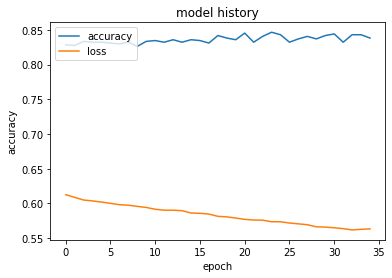

0.8804348111152649
[[11  2  0  0  0  0]
 [ 0 17  0  0  0  1]
 [ 0  0  0  7  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0  0 25]]
None
----------------------------
Epoch 1/35
837/837 [==============================] - 121s 144ms/step - loss: 0.5609 - accuracy: 0.8435
Epoch 2/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5573 - accuracy: 0.8303
Epoch 3/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5576 - accuracy: 0.8363
Epoch 4/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5540 - accuracy: 0.8399
Epoch 5/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5511 - accuracy: 0.8387
Epoch 6/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5516 - accuracy: 0.8447
Epoch 7/35
837/837 [==============================] - 125s 149ms/step - loss: 0.5502 - accuracy: 0.8375
Epoch 8/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5486 - accur

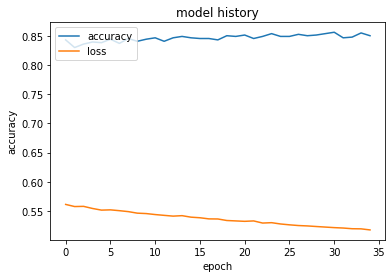

0.9111111164093018
[[13  0  0  0  0  0]
 [ 0 16  1  0  0  0]
 [ 0  0  0  6  0  1]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0  0 25]]
None
----------------------------
Epoch 1/35
837/837 [==============================] - 121s 145ms/step - loss: 0.5259 - accuracy: 0.8471
Epoch 2/35
837/837 [==============================] - 128s 153ms/step - loss: 0.5193 - accuracy: 0.8578
Epoch 3/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5203 - accuracy: 0.8471
Epoch 4/35
837/837 [==============================] - 122s 146ms/step - loss: 0.5181 - accuracy: 0.8507
Epoch 5/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5162 - accuracy: 0.8495
Epoch 6/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5150 - accuracy: 0.8554
Epoch 7/35
837/837 [==============================] - 124s 148ms/step - loss: 0.5150 - accuracy: 0.8519
Epoch 8/35
837/837 [==============================] - 123s 147ms/step - loss: 0.5128 - accur

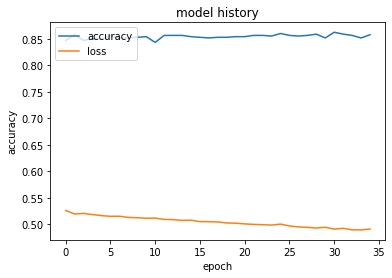

0.8666666746139526
[[ 9  4  0  0  0  0]
 [ 0 17  0  0  0  0]
 [ 0  0  1  6  0  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0  8  0]
 [ 1  0  0  0  1 23]]
None
----------------------------
Epoch 1/35
838/838 [==============================] - 122s 145ms/step - loss: 0.4786 - accuracy: 0.8580
Epoch 2/35
838/838 [==============================] - 124s 147ms/step - loss: 0.4730 - accuracy: 0.8640
Epoch 3/35
838/838 [==============================] - 123s 147ms/step - loss: 0.4717 - accuracy: 0.8640
Epoch 4/35
838/838 [==============================] - 123s 147ms/step - loss: 0.4712 - accuracy: 0.8640
Epoch 5/35
838/838 [==============================] - 123s 147ms/step - loss: 0.4698 - accuracy: 0.8616
Epoch 6/35
838/838 [==============================] - 124s 148ms/step - loss: 0.4692 - accuracy: 0.8711
Epoch 7/35
838/838 [==============================] - 123s 147ms/step - loss: 0.4678 - accuracy: 0.8652
Epoch 8/35
838/838 [==============================] - 124s 148ms/step - loss: 0.4674 - accur

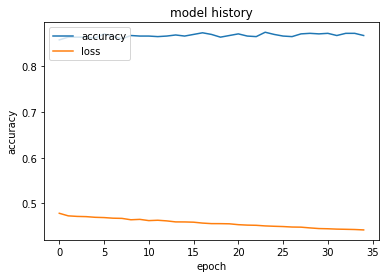

0.8426966071128845
[[ 9  4  0  0  0  0]
 [ 0 16  0  0  1  0]
 [ 0  0  4  3  0  0]
 [ 0  0  0 17  3  0]
 [ 0  0  0  0  5  3]
 [ 0  0  0  0  0 24]]
None
----------------------------


In [8]:
prediction=[]
confusion_list=[]
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
num_classes = 6
for train_index, test_index in skf.split(img_data, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    x_train=x_train.reshape(x_train.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT,3)
    x_test=x_test.reshape(x_test.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT,3)
    y_train =to_categorical(y_train, num_classes)
    y_test =to_categorical(y_test, num_classes)
    X,Y,Z=cnn_model(x_train,x_test,y_test,y_train)
    prediction.append(X)
    confusion_list.append(Y)
    print(X)
    print(Y)
    print(Z)
    print("----------------------------")